# XWTs_changes_ERA20C.ipynb

#!/usr/bin/env python

    File name: XWTs_changes_ERA20C.ipynb
    Author: Andreas Prein
    E-mail: prein@ucar.edu
    Date created: 06.05.2020
    Date last modified: 06.05.2020

    ############################################################## 
    Purpos:

    Load Proprocessed data from:
    /glade/u/home/prein/projects/2019_Janice-CA-Fire-WTs/programs/ERA20C_XWTing/XWTs_in_Model.py

    1) Read in the Eucledian Distance metrics for all HUC2 regions
    2) Calculate the frequency changes during the 20th century
    3) Plot the results on a map

'''

In [1]:
from dateutil import rrule
import datetime
import glob
from netCDF4 import Dataset
import sys, traceback
import dateutil.parser as dparser
import string
from pdb import set_trace as stop
import numpy as np
import numpy.ma as ma
import os
from mpl_toolkits import basemap
import pickle
import subprocess
import pandas as pd
from scipy import stats
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import pylab as plt
import random
import scipy.ndimage as ndimage
import scipy
import shapefile
import matplotlib.path as mplPath
from matplotlib.patches import Polygon as Polygon2
# Cluster specific modules
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.vq import kmeans2,vq, whiten
from scipy.ndimage import gaussian_filter
import seaborn as sns
# import metpy.calc as mpcalc
import shapefile as shp
import sys
import matplotlib.gridspec as gridspec
from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from pylab import *
import string
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import shapefile
from scipy import signal
from numpy.linalg import lstsq
import random

from Functions_Extreme_WTs import XWT
from Functions_Extreme_WTs import MRR, MRD, perkins_skill
from Functions_Extreme_WTs import PreprocessWTdata
from Functions_Extreme_WTs import EucledianDistance

def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df


import scipy.interpolate as spint
import scipy.spatial.qhull as qhull
import numpy as np

def interp_weights(xy, uv,d=2):
    tri = qhull.Delaunay(xy)
    simplex = tri.find_simplex(uv)
    vertices = np.take(tri.simplices, simplex, axis=0)
    temp = np.take(tri.transform, simplex, axis=0)
    delta = uv - temp[:, d]
    bary = np.einsum('njk,nk->nj', temp[:, :d, :], delta)
    return vertices, np.hstack((bary, 1 - bary.sum(axis=1, keepdims=True)))

def interpolate(values, vtx, wts):
    return np.einsum('nj,nj->n', np.take(values, vtx), wts)


# piecewise regression
ramp = lambda u: np.maximum( u, 0 )
step = lambda u: ( u > 0 ).astype(float)

def SegmentedLinearReg( X, Y, breakpoints ):
    nIterationMax = 10

    breakpoints = np.sort( np.array(breakpoints) )

    dt = np.min( np.diff(X) )
    ones = np.ones_like(X)

    for i in range( nIterationMax ):
        # Linear regression:  solve A*p = Y
        Rk = [ramp( X - xk ) for xk in breakpoints ]
        Sk = [step( X - xk ) for xk in breakpoints ]
        A = np.array([ ones, X ] + Rk + Sk )
        p =  lstsq(A.transpose(), Y, rcond=None)[0] 

        # Parameters identification:
        a, b = p[0:2]
        ck = p[ 2:2+len(breakpoints) ]
        dk = p[ 2+len(breakpoints): ]

        # Estimation of the next break-points:
        newBreakpoints = breakpoints - dk/ck 

        # Stop condition
        if np.max(np.abs(newBreakpoints - breakpoints)) < dt/5:
            break
        breakpoints = newBreakpoints
    else:
        print( 'maximum iteration reached' )

    # Compute the final segmented fit:
    Xsolution = np.insert( np.append( breakpoints, max(X) ), 0, min(X) )
    ones =  np.ones_like(Xsolution) 
    Rk = [ c*ramp( Xsolution - x0 ) for x0, c in zip(breakpoints, ck) ]

    Ysolution = a*ones + b*Xsolution + np.sum( Rk, axis=0 )

    return Xsolution, Ysolution


def XWTstats(EucledianDist,
            Filtered,
            E20_time,
            E20DD):
    
    FilteredTarWTE=np.zeros((EucledianDist.shape[1],100))
    FilteredTar = np.copy(Filtered)
    Frequency=np.zeros((EucledianDist.shape[1],100,2))
    # calculate monthly occurance histogram for target region
    MinED=np.min(EucledianDist,axis=1)
    MinEDtype = np.argmin(EucledianDist,axis=1)
    RP_act=1/3.
    E20YYYY=np.unique(E20_time.year)
    SORT = np.argsort(MinED)
    Treshhold=MinED[SORT][int(len(E20YYYY)*RP_act)]

    # Differentiate between WTs
    Montlhy_ocXWT=np.zeros((12,EucledianDist.shape[1],2))
    MinEDtype = np.argmin(EucledianDist,axis=1)
    PAS = ((E20DD.year <= 1930) & (E20DD.year >= 1900))
    CUR = ((E20DD.year <= 2015) & (E20DD.year >= 1976))
    for wt in range(EucledianDist.shape[1]):
        # calculate monthly occurance histogram for target region for each XWT
        MinED=EucledianDist[:,wt]
        SORT = np.argsort(MinED)
        Treshhold=MinED[SORT][int(len(E20YYYY)*RP_act)]
#         Treshhold=np.sort(MinED)[int(len(E20YYYY)*RP_act)]
        Occurance=(MinED <= Treshhold)
        
        WTact=np.copy(MinEDtype+1)
        WTact[WTact != (wt+1)]=0
        WTact[Occurance !=1 ]=0

        MM_ovact = np.array(E20DD.month)
        MM_ovact[WTact != (wt+1)]=0
        for mm in range(12):
            Montlhy_ocXWT[mm,wt,0]=np.sum(MM_ovact[PAS] == (mm+1))
            Montlhy_ocXWT[mm,wt,1]=np.sum(MM_ovact[CUR] == (mm+1))

        EDspace=np.linspace(EucledianDist[:,wt].min(),np.percentile(EucledianDist[:,wt],0.5),100)
        RP=np.zeros((len(EDspace)))
        for ed in range(len(EDspace)):
            TEST=(EucledianDist[:,wt] <= EDspace[ed])
            ExtrFrY=float(np.sum(TEST))/len(E20YYYY)
            ExpectedFrequency=np.cumsum(np.array([ExtrFrY]*len(E20YYYY)))
            RP[ed]=ExtrFrY
            Ref = np.sum(TEST[PAS])
            Cur = np.sum(TEST[CUR])
            FilteredTarWTE[wt,ed] = ((Cur-Ref)/float(Ref))*100
            Frequency[wt,ed,:] = [Ref,Cur]
        FilteredTarWTE[wt,:] = scipy.ndimage.filters.convolve1d(FilteredTarWTE[wt,:], b/b.sum())
    return FilteredTarWTE,Montlhy_ocXWT, RP, Frequency

### Program Setup

In [2]:
PreprocessedData='/glade/campaign/mmm/c3we/prein/Papers/2019_Janice-CA-Fire-WTs/data/XWT_ERA20C/ERA20C_XWTs_Eucledian-Distances.pkl'
PreprocessedData20CR='/glade/campaign/mmm/c3we/prein/Papers/2019_Janice-CA-Fire-WTs/data/XWT_20CR_v3/AUC-APR/'
sPlotDir='/glade/u/home/prein/projects/2019_Janice-CA-Fire-WTs/plots/XWTs_in_ERA20C/'# +str(iNrOfExtremes)+'_Events/'
Regions=['Bay_Area','Central_Coast','LA','Modoc','Northeast','San_Diego','Siearas_East','Siearas_West']
REGIONS = ['Bay Area','Central Coast','LA','Modoc','Northern','San Diego','Sieara-East','Sieara-West']
# DW_Regions=['San_Diego','LA','Central_Coast','Bay_Area','Northeast','Modoc','Siearas_East','Siearas_West']
SortXWTs = [[0,1],
           [2,0,1],
           [0,1],
           [1,0],
           [3,0,2,1], #[2,1,0],
           [0,1],
           [1,0,2],
           [2,1,0]]

sShapefiles='/glade/u/home/prein/projects/2019_Janice-CA-Fire-WTs/Shapefiles/'
sRegion = 'LA'
REG=2
ClimLen=30

### Load the proprocessed ERA-20C data and calculate frequency changes

In [3]:
file2 = open(PreprocessedData, 'rb')
DATA = pickle.load(file2)
file2.close()
RP=DATA['LA']['RP']
RPs=[1/3.,1/6] #,1/10]
RetLev = ['1 in 3','1 in 6'] #,'1 in 10']
iRP=[np.argmin(np.abs(RPs[ii]-RP)) for ii in range(len(RPs))]
Regions_RP_Z=np.zeros((len(Regions),len(iRP),2))

dStartDayE20=datetime.datetime(1900, 1, 1,0)
dStopDayE20=datetime.datetime(2010, 12, 31,23)
E20MM = pd.date_range(dStartDayE20, end=dStopDayE20, freq='M')
E20DD = pd.date_range(dStartDayE20, end=dStopDayE20, freq='D')
for re in range(len(Regions)):
    SRdata=DATA[Regions[re]]
    EucledianDist=SRdata['EucledianDist_orig']
    ChangeInFr=SRdata['ChangeInFr']
#     RP=SRdata['RP']
    E20_time=SRdata['E20_time']
    
    b = signal.gaussian(40, 10)
    Filtered = scipy.ndimage.filters.convolve1d(ChangeInFr, b/b.sum())
#     RandomChance[RandomChance == np.inf]=np.nan
    if Regions[re] == sRegion:
        FilteredTarWTE, Montlhy_ocXWT, RPE20 , FrequencyE20= XWTstats(EucledianDist,Filtered,E20_time,E20DD)
    
    
    
#     # calculate the standard deviation from random time series
#     Mean=np.nanmean(RandomChance, axis=1)
#     STD=np.nanstd(RandomChance, axis=1)

#     Zscore=np.array([(Filtered[ii]-Mean[ii])/STD[ii] for ii in range(len(Filtered))])
#     for rp in range(len(iRP)):
#         Regions_RP_Z[re,rp,0]=Filtered[iRP[rp]]
#         Regions_RP_Z[re,rp,1]=Zscore[iRP[rp]]
        

### Load the preprocessed 20CR_v3 data

In [4]:
re=2
NOAA_Datact = PreprocessedData20CR+'20CR_v3_XWTs_Eucledian-Distances_'+Regions[re]+'.pkl'
file2 = open(NOAA_Datact, 'rb')
DATA = pickle.load(file2)
file2.close()
FilteredTar20CR = np.zeros((80,len(Regions),4,100)); FilteredTar20CR[:]=np.nan

dStartDayE20=datetime.datetime(1900, 1, 1,0)
dStopDayE20=datetime.datetime(2015, 12, 31,23)
E20MMN = pd.date_range(dStartDayE20, end=dStopDayE20, freq='M')
E20DDN = pd.date_range(dStartDayE20, end=dStopDayE20, freq='D')
E20YYYY20CR = np.unique(E20MMN.year)
RP20CR=DATA['LA_'+str(0).zfill(3)]['RP']
RPs=[1/3.,1/6] #,1/10]
RetLev = ['1 in 3','1 in 6'] #,'1 in 10']
iRP20CR = [np.argmin(np.abs(RPs[ii]-RP20CR)) for ii in range(len(RPs))]
Montlhy_ocXWT20CR = np.zeros((80,len(Regions),12,4,2)); Montlhy_ocXWT20CR[:]=np.nan
FrequencyChenge20CR=np.zeros((80, len(Regions),4,100,2)); FrequencyChenge20CR[:]=np.nan
for mem in range(80):
#     print('    proces member '+str(mem))
    for re in range(len(Regions)):
        try:
            NOAA_Datact = PreprocessedData20CR+'20CR_v3_XWTs_Eucledian-Distances_'+Regions[re]+'.pkl'
            file2 = open(NOAA_Datact, 'rb')
            DATA = pickle.load(file2)
            file2.close()
            SRdata=DATA[Regions[re]+'_'+str(mem).zfill(3)]
            EucledianDist=SRdata['EucledianDist_orig']
    #         RandomChance=SRdata['RandomChance']
            ChangeInFr=SRdata['ChangeInFr']
            RP=SRdata['RP']
            E20_time20CR=SRdata['E20_time']

            b = signal.gaussian(40, 10)
            Filtered = scipy.ndimage.filters.convolve1d(ChangeInFr, b/b.sum())
    #         RandomChance[RandomChance == np.inf]=np.nan
            FILT, MONfr, RP20CR, FRchange = XWTstats(EucledianDist,Filtered,E20_time20CR,E20DDN)
            FilteredTar20CR[mem,re,:FILT.shape[0],:] = FILT
            Montlhy_ocXWT20CR[mem,re,:,:MONfr.shape[1],:] = MONfr
            FrequencyChenge20CR[mem,re,:MONfr.shape[1],:,:] = FRchange
        except:
            continue



### Calcoulate probability of XWTs within 7 days

In [5]:
RP_act=0.33 #1/3.
YEARS = np.unique(E20DDN.year)
XWT_clustering = np.zeros((len(E20DDN), len(Regions), 80,4))
for re in range(len(Regions)):
    try:
        NOAA_Datact = PreprocessedData20CR+'20CR_v3_XWTs_Eucledian-Distances_'+Regions[re]+'.pkl'
        file2 = open(NOAA_Datact, 'rb')
        DATA = pickle.load(file2)
        file2.close()
        SRdata=DATA[Regions[re]+'_'+str(mem).zfill(3)]
        EucledianDist=SRdata['EucledianDist_orig']
        for mem in range(80):
            SRdata=DATA[Regions[re]+'_'+str(mem).zfill(3)]
            EucledianDist=SRdata['EucledianDist_orig']
            for wt in range(EucledianDist.shape[1]):
                iEXTR = np.argsort(EucledianDist[:,wt], axis=0)[:int(len(YEARS)*RP_act)]
                XWT_clustering[iEXTR,re,mem,wt] = 1
    except:
        continue

In [6]:
XWToccurance = np.sum(XWT_clustering, axis=3)
XWT_Clustering = np.zeros((2,len(Regions), 80))
TimeWindow = 7
for re in range(len(Regions)):
    for mem in range(80):
        Clustering = np.convolve(XWToccurance[:,re,mem], np.ones(TimeWindow), mode='same')
        TMPdata = np.where((Clustering[E20DDN.year < 1939] > 1))[0]
        XWT_Clustering[0,re,mem] = np.sum((TMPdata[1:]-TMPdata[:-1]) > 1)
        TMPdata = np.where((Clustering[E20DDN.year > 1976] > 1))[0]
        XWT_Clustering[1,re,mem] = np.sum((TMPdata[1:]-TMPdata[:-1]) > 1)
iXWTs = [len(SortXWTs[ii]) for ii in range(len(SortXWTs))]

### Calculate random chance

In [7]:
# calculate random chance
BSnr=1000
RPcommon = np.append(RP, np.linspace(RP[-1],10,100))
RandomChance=np.zeros((len(RPcommon),BSnr))
for pe in range(len(RPcommon)):
    NrOfEvents=(RPcommon*len(E20YYYY20CR))[pe]
    for bs in range(BSnr):
        RandomDays=np.sort(np.array([random.randint(0, len(E20YYYY20CR)-1) for ii in range(int(NrOfEvents))]))
        RandRecord=np.zeros((len(E20YYYY20CR)))
        for ii in range(len(RandomDays)):
            RandRecord[RandomDays[ii]]=RandRecord[RandomDays[ii]]+1
        Ref=np.sum(RandRecord[:ClimLen])
        Cur=np.sum(RandRecord[-ClimLen:])
        RandomChance[pe,bs]=((Cur-Ref)/float(Ref))*100

[  72.72727273   40.          -80.          -50.         -100.
           nan           nan           nan -100.           58.13953488
  175.11111111   59.5       ]
[         nan          nan          nan          nan          inf
 600.           6.81362725  71.71717172 -14.75409836          nan
          nan          nan]
[         nan          nan          nan          inf  69.23076923
 -29.62962963 328.04878049 196.83257919  22.12389381 -76.47058824
          inf          nan]
[          nan           nan -100.         -100.          522.22222222
  195.23809524  201.4084507    68.7804878   -11.88118812  -17.58241758
  -50.         -100.        ]
[242.52873563 -49.0616622   33.55704698  38.38383838 -50.73995772
  -5.63380282 -38.7755102   21.42857143]
[242.52873563 -49.0616622   33.55704698  38.38383838 -50.73995772
  -5.63380282 -38.7755102   21.42857143]
[242.52873563 -49.0616622   33.55704698  38.38383838 -50.73995772
  -5.63380282 -38.7755102   21.42857143]
[242.52873563 -49.06166

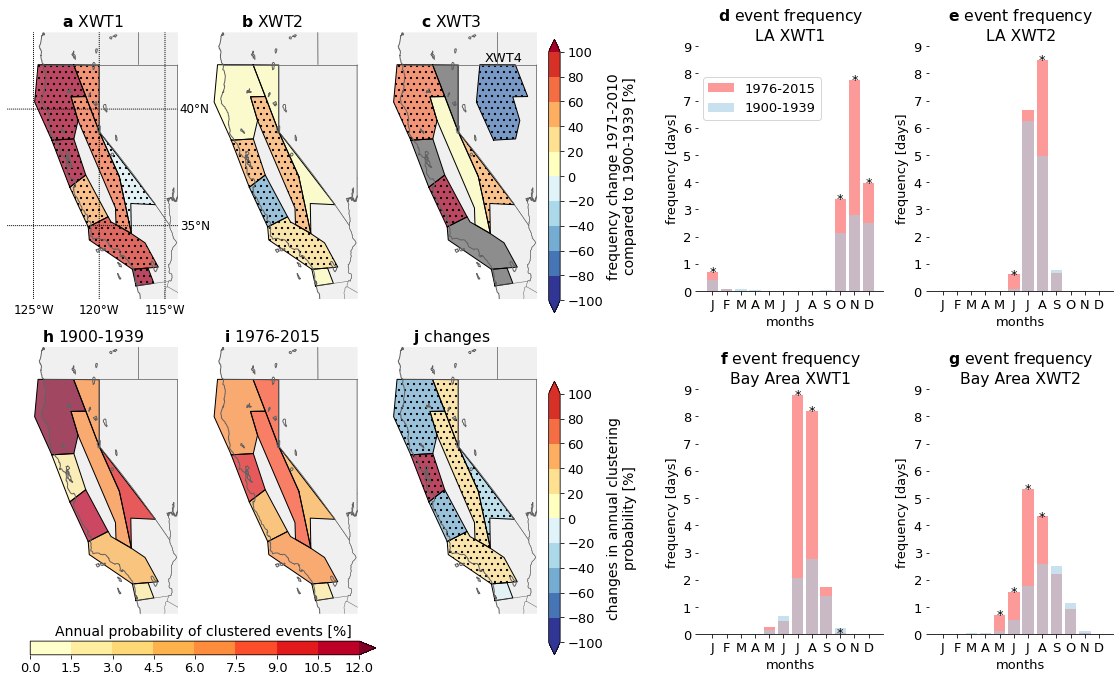

In [14]:
plt.rcParams.update({'font.size': 13})
rgsLableABC=list(string.ascii_lowercase)
ReturnLevel=2
Regions_RP_Z[Regions_RP_Z == np.inf]=np.nan

fig = plt.figure(figsize=(16,9.5))

# ======================================
# changes on map
gs1 = gridspec.GridSpec(1,3)
gs1.update(left=0.02, right=0.48,
           bottom=0.56, top=0.95,
           wspace=0.05, hspace=0.20)
cmap = matplotlib.cm.get_cmap('coolwarm')
COLORS = ['#a50026','#d73027','#f46d43','#fdae61','#fee090','#ffffbf','#e0f3f8','#abd9e9','#74add1','#4575b4','#313695'][::-1]
colors=cmap(np.linspace(0,1,len(COLORS)))
i3yearEv = np.argmin(np.abs((1./RP20CR)-3))
# loop over the two statistics
pl=0
# replace Infs with NaNs
for re in range(len(Regions)):
    for wt in range(3):
        FilteredTar20CR[:,re,wt,:][FilteredTar20CR[:,re,wt,:] > 99999999] = np.nan
for wt in range(3):
    
    ax = plt.subplot(gs1[0,wt])
#     ScoresACT=np.nanmean(Regions_RP_Z_20CR[:,:,pl,wt,0], axis=0) #    Regions_RP_Z[:,pl,0]
    Stat='annual probability of clustered XWTs [%]'
    levels=np.linspace(-140,140,len(colors))
    
    plt.axis('off')
    m = Basemap(projection='cea',\
                llcrnrlat= 32 ,urcrnrlat=43.5,\
                llcrnrlon=-127,urcrnrlon=-114,resolution='i', fix_aspect=False) #, epsg=4269)
    for re in range(len(Regions)):
        try:
            WT = SortXWTs[re][wt]
        except:
            WT = wt
        ScoresACT = np.nanmean(FilteredTar20CR[:,:,WT,i3yearEv], axis=0)
#         ScoresACT = ((np.nanmean(XWT_Clustering[0,re,:])/iXWTs[re])/40)*100.
        Sig=scipy.stats.mannwhitneyu(FrequencyChenge20CR[:,re,WT,i3yearEv,0], FrequencyChenge20CR[:,re,WT,i3yearEv,1])[1]
        sf = shp.Reader(sShapefiles+Regions[re])
        df = read_shapefile(sf)
        for sf in range(df.shape[0]):
            ctr = df['coords'][sf]
            if len(ctr) > 10000:
                ctr=np.array(ctr)[::100,:] # carsen the shapefile accuracy
            else:
                ctr=np.array(ctr)
        try:
            iCol=np.where(levels < ScoresACT[re])[0][-1]
        except:
            if ScoresACT[re] < levels[0]:
                iCol=0
            else:
                iCol=len(colors)-1
        # add shapefile of catchment
        XX,YY=m(ctr[:,0], ctr[:,1])
        if pl == 0:
            m.plot(XX,YY, c='k', lw=1)
        else:
            m.plot(XX,YY, c='k', lw=1)
            
        if np.isnan(ScoresACT[re]) == 0:
            ax.fill(XX,YY, COLORS[iCol], alpha=0.7, zorder=2)
            # test significance
            if (Sig < 0.025):
                ax.fill(XX,YY, hatch='..', facecolor="none", zorder=3)
        else:
            ax.fill(XX,YY, '#636363', alpha=0.7, zorder=2)
            


    plt.title(r"$\bf{" + str(rgsLableABC[wt])+ "}$"+' XWT'+str(wt+1))

    m.drawcountries(color='#636363', zorder=10)
    m.drawstates(color='#636363', zorder=10)
#     m.drawrivers(color='dodgerblue',linewidth=0.5,zorder=10)  
    m.fillcontinents(color='#f0f0f0', zorder=1)
    m.drawcoastlines(color='#636363', zorder=10)
    if wt == 0:
        parallels = np.arange(0.,81,5.)
        # labels = [left,right,top,bottom]
        m.drawparallels(parallels,labels=[False,True,True,False], fontsize=12)
        meridians = np.arange(10.,351.,5.)
        m.drawmeridians(meridians,labels=[True,False,False,True], fontsize=12)

# Add XWT4 for Northeastern region
for wt in [3]:
#     ScoresACT=np.nanmean(Regions_RP_Z_20CR[:,:,pl,wt,0], axis=0) #    Regions_RP_Z[:,pl,0]
    Stat='frequency change 1971-2010\ncompared to 1900-1939 [%]'
    levels=np.linspace(-100,100,len(colors))
    
    plt.axis('off')
    m = Basemap(projection='cea',\
                llcrnrlat= 32 ,urcrnrlat=43.5,\
                llcrnrlon=-127,urcrnrlon=-114,resolution='i', fix_aspect=False) #, epsg=4269)
    for re in [4]:
        try:
            WT = SortXWTs[re][wt]
        except:
            WT = wt
        ScoresACT = np.nanmean(FilteredTar20CR[:,:,WT,i3yearEv], axis=0)
        Sig=scipy.stats.mannwhitneyu(FrequencyChenge20CR[:,re,WT,i3yearEv,0], FrequencyChenge20CR[:,re,WT,i3yearEv,1])[1]
        sf = shp.Reader(sShapefiles+Regions[re])
        df = read_shapefile(sf)
        for sf in range(df.shape[0]):
            ctr = df['coords'][sf]
            if len(ctr) > 10000:
                ctr=np.array(ctr)[::100,:] # carsen the shapefile accuracy
            else:
                ctr=np.array(ctr)
        try:
            iCol=np.where(levels < ScoresACT[re])[0][-1]
        except:
            if ScoresACT[re] < levels[0]:
                iCol=0
            else:
                iCol=len(colors)-1
        # add shapefile of catchment
        XX,YY=m(ctr[:,0], ctr[:,1])
        XX = XX+700000
        if pl == 0:
            m.plot(XX,YY, c='k', lw=1)
        else:
            m.plot(XX,YY, c='k', lw=1)
            
        if np.isnan(ScoresACT[re]) == 0:
            ax.fill(XX,YY, COLORS[iCol], alpha=0.7, zorder=2)
            # test significance
            if (Sig < 0.025):
                ax.fill(XX,YY, hatch='..', facecolor="none", zorder=3)
        else:
            ax.fill(XX,YY, '#636363', alpha=0.7, zorder=2)
        ax.text(np.mean(XX), np.max(YY), 'XWT4', va='bottom', ha='center')

# add colorbar
a = np.array([[levels[0],levels[-1]]])
img = plt.contourf([[0,0],[0,0]], [[0,0],[0,0]], colors=COLORS,levels=levels, extend='both')
img.cmap.set_over('#a50026')
img.cmap.set_under('#313695')
CbarAx = axes([0.49, 0.54, 0.01, 0.4])
cb = colorbar(img, cax = CbarAx, orientation='vertical', ticks=np.arange(-100,120,20), extend='both')
cb.set_label(Stat, fontsize=14)
        
    

# ======================================
# Monthly occurance frequency in target region
gs1 = gridspec.GridSpec(2,2)
gs1.update(left=0.62, right=0.98,
           bottom=0.07, top=0.93,
           wspace=0.25, hspace=0.40)
sMonths = ['J','F','M','A','M','J','J','A','S','O','N','D']
ii =0
for REG in [2,0]:
    for wt in range(2):
        WT = SortXWTs[REG][wt]
        ax = plt.subplot(gs1[ii,WT])
        sMonthsAct = np.copy(sMonths); sMonthsAct[:] = ' '
        # # ECMWF
        # Past=Montlhy_ocXWT[:,1,0]
        # Current=Montlhy_ocXWT[:,1,1]
        # NOAA
        Past=np.mean(Montlhy_ocXWT20CR[:,REG,:,wt,0], axis=0)
        errorP = np.std(Montlhy_ocXWT20CR[:,REG,:,wt,0], axis=0)
        Current=np.mean(Montlhy_ocXWT20CR[:,REG,:,wt,1], axis=0)
        errorC = np.std(Montlhy_ocXWT20CR[:,REG,:,wt,1], axis=0)
        # are changes significant?
        MWU_P = np.zeros((12)); MWU_P[:] = np.nan
        for mm in range(12):
            try:
                MWU_P[mm] = scipy.stats.mannwhitneyu(Montlhy_ocXWT20CR[:,REG,mm,wt,0], Montlhy_ocXWT20CR[:,REG,mm,wt,1])[1]
                if MWU_P[mm] < 0.025:
                    sMonthsAct[mm] = '*'
            except:
                continue

        plt.bar(range(1,13), Current, align='center', alpha=1, color="#fb9a99", label='1976-2015') #, yerr=errorP)
        plt.bar(range(1,13), Past, align='center', alpha=0.6, color="#a6cee3", label='1900-1939')#, yerr=errorC)
        print(((Current-Past)/Past)*100)
        # show significance
        [plt.text(mm, Current[mm-1], sMonthsAct[mm-1], ha = 'center', va = 'center') for mm in range(1,13)]
        ax.set_xlabel('months')
        ax.set_ylabel('frequency [days]')
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        # ax.text(0.05,0.95, rgsLableABC[2]+') monthly event\nfrequency in '+sRegion, ha='left',va='top', \
        #                  transform = ax.transAxes, fontname="Times New Roman Bold", fontsize=16) #, weight='bold')
        plt.title(r"$\bf{" + str(rgsLableABC[3+wt+ii*2])+ "}$"+' event frequency\n'+REGIONS[REG]+' XWT'+str(WT+1))
        if (wt == 0) & (REG == 2):
            plt.legend(bbox_to_anchor=(0.7,0.9))
#         plt.grid(axis='y')
        ax.set_xticks((1,2,3,4,5,6,7,8,9,10,11,12))
        ax.set_xticklabels(sMonths)
        plt.ylim([0,9])
    ii=ii+1
    
    
    
# ======================================
# probability of clustered events
sPeriods = ['1900-1939','1976-2015']
gs1 = gridspec.GridSpec(1,3)
gs1.update(left=0.02, right=0.48,
           bottom=0.1, top=0.49,
           wspace=0.05, hspace=0.20)
cmap = matplotlib.cm.get_cmap('coolwarm')
COLORS = ['#ffffcc','#ffeda0','#fed976','#feb24c','#fd8d3c','#fc4e2a','#e31a1c','#bd0026','#800026']
colors=cmap(np.linspace(0,1,len(COLORS)))
i3yearEv = np.argmin(np.abs((1./RP20CR)-3))
# loop over the two statistics
pl=0
for st in range(2):
    ax = plt.subplot(gs1[0,st])
#     ScoresACT=np.nanmean(Regions_RP_Z_20CR[:,:,pl,wt,0], axis=0) #    Regions_RP_Z[:,pl,0]
    Stat='Annual probability of clustered events [%]'
    levels=np.linspace(0,12,len(colors))
    
    plt.axis('off')
    m = Basemap(projection='cea',\
                llcrnrlat= 32 ,urcrnrlat=43.5,\
                llcrnrlon=-127,urcrnrlon=-114,resolution='i', fix_aspect=False) #, epsg=4269)
    for re in range(len(Regions)):
        try:
            WT = SortXWTs[re][wt]
        except:
            WT = wt
        ScoresACT = ((np.nanmean(XWT_Clustering[st,:,:], axis=1))/40)*100
        Sig=scipy.stats.mannwhitneyu(FrequencyChenge20CR[:,re,WT,i3yearEv,0], FrequencyChenge20CR[:,re,WT,i3yearEv,1])[1]
        sf = shp.Reader(sShapefiles+Regions[re])
        df = read_shapefile(sf)
        for sf in range(df.shape[0]):
            ctr = df['coords'][sf]
            if len(ctr) > 10000:
                ctr=np.array(ctr)[::100,:] # carsen the shapefile accuracy
            else:
                ctr=np.array(ctr)
        try:
            iCol=np.where(levels < ScoresACT[re])[0][-1]
        except:
            if ScoresACT[re] < levels[0]:
                iCol=0
            else:
                iCol=len(colors)-1
        # add shapefile of catchment
        XX,YY=m(ctr[:,0], ctr[:,1])
        if pl == 0:
            m.plot(XX,YY, c='k', lw=1)
        else:
            m.plot(XX,YY, c='k', lw=1)
            
        if np.isnan(ScoresACT[re]) == 0:
            ax.fill(XX,YY, COLORS[iCol], alpha=0.7, zorder=2)
#             # test significance
#             if (Sig < 0.025):
#                 ax.fill(XX,YY, hatch='..', facecolor="none", zorder=3)
        else:
            ax.fill(XX,YY, '#636363', alpha=0.7, zorder=2)
            
    plt.title(r"$\bf{" + str(rgsLableABC[7+st])+ "}$"+' '+sPeriods[st])
    m.drawcountries(color='#636363', zorder=10)
    m.drawstates(color='#636363', zorder=10)
    m.fillcontinents(color='#f0f0f0', zorder=1)
    m.drawcoastlines(color='#636363', zorder=10)
# add colorbar
a = np.array([[levels[0],levels[-1]]])
img = plt.contourf([[0,0],[0,0]], [[0,0],[0,0]], colors=COLORS,levels=levels, extend='max')
# img.cmap.set_over('#a50026')
# img.cmap.set_under('#313695')
CbarAx = axes([0.04, 0.04, 0.3, 0.02])
cb = colorbar(img, cax = CbarAx, orientation='horizontal', ticks=levels, extend='both')
cb.ax.set_title(Stat, fontsize=14)


# ======================================
# frequency changes in clustered events
ax = plt.subplot(gs1[0,2])
Stat='changes in annual clustering\nprobability [%]'
COLORS = ['#a50026','#d73027','#f46d43','#fdae61','#fee090','#ffffbf','#e0f3f8','#abd9e9','#74add1','#4575b4','#313695'][::-1]
levels=np.linspace(-100,100,len(COLORS))

plt.axis('off')
m = Basemap(projection='cea',\
            llcrnrlat= 32 ,urcrnrlat=43.5,\
            llcrnrlon=-127,urcrnrlon=-114,resolution='i', fix_aspect=False) #, epsg=4269)
for re in range(len(Regions)):
    ScoresACT = ((np.sum(XWT_Clustering[1,:,:], axis=1)/np.sum(XWT_Clustering[0,:,:], axis=1))-1)*100
    print(ScoresACT)
    Sig=scipy.stats.mannwhitneyu(XWT_Clustering[0,re,:], XWT_Clustering[1,re,:])[1]
#     print(Regions[re]+' Sig='+str(Sig))
    sf = shp.Reader(sShapefiles+Regions[re])
    df = read_shapefile(sf)
    for sf in range(df.shape[0]):
        ctr = df['coords'][sf]
        if len(ctr) > 10000:
            ctr=np.array(ctr)[::100,:] # carsen the shapefile accuracy
        else:
            ctr=np.array(ctr)
    try:
        iCol=np.where(levels < ScoresACT[re])[0][-1]
    except:
        if ScoresACT[re] < levels[0]:
            iCol=0
        else:
            iCol=len(colors)-1
    # add shapefile of catchment
    XX,YY=m(ctr[:,0], ctr[:,1])
    if pl == 0:
        m.plot(XX,YY, c='k', lw=1)
    else:
        m.plot(XX,YY, c='k', lw=1)

    if np.isnan(ScoresACT[re]) == 0:
        ax.fill(XX,YY, COLORS[iCol], alpha=0.7, zorder=2)
        # test significance
        if (Sig < 0.025):
            ax.fill(XX,YY, hatch='..', facecolor="none", zorder=3)
    else:
        ax.fill(XX,YY, '#636363', alpha=0.7, zorder=2)

plt.title(r"$\bf{" + str(rgsLableABC[9])+ "}$"+' changes')

m.drawcountries(color='#636363', zorder=10)
m.drawstates(color='#636363', zorder=10)
#     m.drawrivers(color='dodgerblue',linewidth=0.5,zorder=10)  
m.fillcontinents(color='#f0f0f0', zorder=1)
m.drawcoastlines(color='#636363', zorder=10)
# add colorbar
a = np.array([[levels[0],levels[-1]]])
img = plt.contourf([[0,0],[0,0]], [[0,0],[0,0]], colors=COLORS,levels=levels, extend='both')
# img.cmap.set_over('#a50026')
# img.cmap.set_under('#313695')
CbarAx = axes([0.49, 0.04, 0.01, 0.4])
cb = colorbar(img, cax = CbarAx, orientation='vertical', ticks=levels, extend='both')
cb.set_label(Stat, fontsize=14)
# cb.ax.set_title(Stat, fontsize=16)


# Save the plot
# plt.show()
sPlotFile=sPlotDir
sPlotName= 'ERA20C_XWT-frq-changes_'+sRegion+'.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName)

In [11]:
Regions

['Bay_Area',
 'Central_Coast',
 'LA',
 'Modoc',
 'Northeast',
 'San_Diego',
 'Siearas_East',
 'Siearas_West']

### Plot the results on maps

In [ ]:
plt.rcParams.update({'font.size': 15})
rgsLableABC=list(string.ascii_lowercase)
ReturnLevel=2
Regions_RP_Z[Regions_RP_Z == np.inf]=np.nan

fig = plt.figure(figsize=(16,11))
# ======================================
# changes in Focus region
gs1 = gridspec.GridSpec(1,2)
gs1.update(left=0.08, right=0.95,
           bottom=0.60, top=0.95,
           wspace=0.25, hspace=0.20)
RP_act=0.33 #1/3.


ax = plt.subplot(gs1[0,0])
re=0
file2 = open(PreprocessedData, 'rb')
DATA = pickle.load(file2)
file2.close()
SRdata=DATA[sRegion]# ['San_Diego']
EucledianDist=SRdata['EucledianDist_orig']
ChangeInFr=SRdata['ChangeInFr']
# RP=SRdata['RP']

sRegion = Regions[REG]
file2 = open(PreprocessedData20CR+'20CR_v3_XWTs_Eucledian-Distances_'+Regions[REG]+'.pkl', 'rb')
DATAN = pickle.load(file2)
file2.close()
MEM = 9
SRdata20CR=DATAN[sRegion+'_'+str(MEM).zfill(3)]# ['San_Diego']
EucledianDist20CR=SRdata20CR['EucledianDist_orig']
ChangeInFr20CR=SRdata20CR['ChangeInFr']
# RP20CR=SRdata20CR['RP']

DataColors=['#e31a1c','#1f78b4','#b2df8a']

iWTnr=np.sum(~np.isnan(FilteredTar20CR[0,REG,:,80]))
for wt in range(iWTnr):
#     plt.plot(1./RPE20, FilteredTarWTE[wt,:], c=DataColors[wt], lw=1, label='XWT'+str(wt+1)+' freq. change ERA20C',ls='-')
    for mem in range(80):
        plt.plot(1./RP20CR,FilteredTar20CR[mem,REG,wt,:], c=DataColors[wt], lw=0.1) #, label='XWT freq. change')
    FilteredTar20CR[:,REG,wt,:][FilteredTar20CR[:,REG,wt,:] > 99999999] = np.nan
    plt.plot(1./RP20CR,np.nanmean(FilteredTar20CR[:,REG,wt,:], axis=0), c=DataColors[wt], lw=3, label='XWT'+str(wt+1)+' freq. change NOAA20C')

plt.fill_between(1./RPcommon,np.nanpercentile(RandomChance,25,axis=1), np.nanpercentile(RandomChance,75,axis=1), color='k', alpha=0.2)
plt.fill_between(1./RPcommon,np.nanpercentile(RandomChance,5,axis=1), np.nanpercentile(RandomChance,95,axis=1), color='k', alpha=0.2)


plt.axvline(x=1/RP_act, ls='--', c='k')
plt.axhline(y=0, color='k', linestyle='-')
plt.legend(loc="upper right",
    ncol=1, prop={'size':12})
ax.set_ylabel('frequency change [%]')
ax.set_xlabel('return period [years]')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylim([-100,300])
plt.xlim([0.6,10]) #plt.xlim([1.5,13])
ax.set_xscale('log')
ax.set_xticks((0.6, 1, 2, 3, 5, 10))
# plt.gca().invert_xaxis()
ax.text(0.05,0.95, r"$\bf{" + str(rgsLableABC[0])+ "}$"+' changes in '+sRegion, ha='left',va='top', \
                 transform = ax.transAxes, fontname="Times New Roman Bold", fontsize=14) #, weight='bold')
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())



# # ---------------------
# # Accumulated nr of occurance
# ax = plt.subplot(gs1[0,1])
# from scipy import optimize
# for wt in range(2):
#     WTsel=wt
#     MinED=EucledianDist[:,WTsel] # np.min(EucledianDist,axis=1)
#     E20YYYY=np.unique(E20_time.year)
#     Treshhold=np.sort(MinED)[int(len(E20YYYY)*RP_act)]
#     Occurance=(MinED <= Treshhold)

#     Cumsum=np.cumsum(np.array([np.sum(Occurance[E20_time.year == E20YYYY[yy]]) for yy in range(len(E20YYYY))]))
#     yy = Cumsum.astype('float')
#     xx = np.array(range(len(yy))).astype('float') #E20YYYY.astype('float')[::10]

#     initialBreakpoints = [40, 80]
#     Xsolution, Ysolution = SegmentedLinearReg( xx, yy, initialBreakpoints)
#     plt.plot(Xsolution+E20YYYY.min(), Ysolution, c='k', lw=1, zorder=2)

#     plt.plot(E20YYYY, yy, marker='o', color=DataColors[wt], lw=0, zorder=0)

#     ax.set_ylabel('cumulative occurances [ ]')
#     ax.set_xlabel('years []')
#     ax.spines['right'].set_visible(False)
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.spines['top'].set_visible(False)

#     ax.text(0.05,0.95, r"$\bf{" + str(rgsLableABC[1])+ "}$"+' occurance of 1 in 3 year\nevent in '+sRegion, ha='left',va='top', \
#                      transform = ax.transAxes, fontname="Times New Roman Bold", fontsize=16) #, weight='bold')

#     # Add 20CR
#     NOAA_cumsum = np.zeros((116,80)); NOAA_cumsum[:] = np.nan
#     for MEM in range(80):
#         SRdata20CR=DATAN[sRegion+'_'+str(MEM).zfill(3)]# ['San_Diego']
#         EucledianDist20CR=SRdata20CR['EucledianDist_orig']
#         MinED20CR=EucledianDist20CR[:,WTsel] #np.min(EucledianDist20CR,axis=1)
#         E20YYYY20CR=np.unique(E20_time20CR.year)
#         Treshhold20CR=np.sort(MinED20CR)[int(len(E20YYYY20CR)*RP_act)]
#         Occurance20CR=(MinED20CR <= Treshhold20CR)

#         Cumsum=np.cumsum(np.array([np.sum(Occurance20CR[E20_time20CR.year == E20YYYY20CR[yy]]) for yy in range(len(E20YYYY20CR))]))
#         yy = Cumsum.astype('float')
#         xx = np.array(range(len(yy))).astype('float') #E20YYYY.astype('float')[::10]

#     #     def piecewise_linear(xx, x0, y0, k1, k2):
#     #         return np.piecewise(xx, [xx < x0], [lambda xx:k1*xx + y0-k1*x0, lambda xx:k2*xx + y0-k2*x0])

#     #     pp , e = optimize.curve_fit(piecewise_linear, xx, yy)
#     #     xd = np.linspace(xx.min(), xx.max(), 110)
#     #     plt.plot(E20YYYY20CR, yy,'o', color='#1f78b4',markersize=1)
#         NOAA_cumsum[:,MEM] = yy

# #     Percentiles = np.percentile(NOAA_cumsum, (10,25,75,90), axis=1)
# #     ax.fill_between(E20YYYY20CR, Percentiles[0,:], Percentiles[3,:], alpha=0.2, color='#1f78b4')
#     # ax.fill_between(E20YYYY20CR, Percentiles[1,:], Percentiles[2,:], alpha=0.4, color='#1f78b4')

#     yy = np.nanmean(NOAA_cumsum, axis=1)
#     xx = E20YYYY20CR
#     plt.plot(xx, yy, marker='v', c=DataColors[wt])
#     xx = np.array(range(len(xx)))
#     initialBreakpoints = [40, 80]
#     Xsolution, Ysolution = SegmentedLinearReg( xx, yy, initialBreakpoints)
#     plt.plot(Xsolution+E20YYYY20CR.min(), Ysolution, c='k', lw=1)
    


# ======================================
# Monthly occurance frequency in target region

gs1 = gridspec.GridSpec(1,2)
gs1.update(left=0.52, right=0.95,
           bottom=0.60, top=0.95,
           wspace=0.25, hspace=0.20)
sMonths = ['J','F','M','A','M','J','J','A','S','O','N','D']
for wt in range(2):
    WT = SortXWTs[REG][wt]
    ax = plt.subplot(gs1[0,WT])
    sMonthsAct = np.copy(sMonths); sMonthsAct[:] = ' '
    # # ECMWF
    # Past=Montlhy_ocXWT[:,1,0]
    # Current=Montlhy_ocXWT[:,1,1]
    # NOAA
    Past=np.mean(Montlhy_ocXWT20CR[:,REG,:,wt,0], axis=0)
    errorP = np.std(Montlhy_ocXWT20CR[:,REG,:,wt,0], axis=0)
    Current=np.mean(Montlhy_ocXWT20CR[:,REG,:,wt,1], axis=0)
    errorC = np.std(Montlhy_ocXWT20CR[:,REG,:,wt,1], axis=0)
    # are changes significant?
    MWU_P = np.zeros((12)); MWU_P[:] = np.nan
    for mm in range(12):
        try:
            MWU_P[mm] = scipy.stats.mannwhitneyu(Montlhy_ocXWT20CR[:,REG,mm,wt,0], Montlhy_ocXWT20CR[:,REG,mm,wt,1])[1]
            if MWU_P[mm] < 0.025:
                sMonthsAct[mm] = '*'
        except:
            continue

    plt.bar(range(1,13), Current, align='center', alpha=1, color="#fb9a99", label='1980-2010') #, yerr=errorP)
    plt.bar(range(1,13), Past, align='center', alpha=0.6, color="#a6cee3", label='1900-1930')#, yerr=errorC)
    # show significance
    [plt.text(mm, Current[mm-1], sMonthsAct[mm-1], ha = 'center', va = 'center') for mm in range(1,13)]
    ax.set_xlabel('months')
    ax.set_ylabel('frequency [days]')
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # ax.text(0.05,0.95, rgsLableABC[2]+') monthly event\nfrequency in '+sRegion, ha='left',va='top', \
    #                  transform = ax.transAxes, fontname="Times New Roman Bold", fontsize=16) #, weight='bold')
    plt.title(r"$\bf{" + str(rgsLableABC[1+wt])+ "}$"+' event frequency\n'+sRegion+' XWT'+str(WT+1))
    if wt == 0:
        plt.legend(bbox_to_anchor=(0.7,0.9))
    plt.grid(axis='y')
    ax.set_xticks((1,2,3,4,5,6,7,8,9,10,11,12))
    ax.set_xticklabels(sMonths)
    plt.ylim([0,9])

# # ======================================
# # Onset and decay in target region
gs1 = gridspec.GridSpec(1,2)
gs1.update(left=0.08, right=0.55,
           bottom=0.17, top=0.50,
           wspace=0.25, hspace=0.20)

iDays=10
RP=1/3. #0.3
Xaxis=np.array(range(iDays*2+1))-iDays
Percentiles = [0,25,50,75,100]
EventOnsetDecay = np.zeros((2,2,80, len(Percentiles), iDays*2+1)); EventOnsetDecay[:]=np.nan
ED_max = np.zeros((2,2,80)); ED_max[:] = np.nan
file2 = open(PreprocessedData20CR+'20CR_v3_XWTs_Eucledian-Distances_'+Regions[REG]+'.pkl', 'rb')
DATA = pickle.load(file2)
for wt in range(2):
    WT = SortXWTs[REG][wt]
    ax = plt.subplot(gs1[0,WT])
    for mem in range(80):
        for re in [REG]:# range(len(Regions)):
            SRdata=DATA[Regions[re]+'_'+str(mem).zfill(3)]
            EucledianDist=SRdata['EucledianDist_orig']
    
            E20YYYY=np.unique(E20_time20CR.year)
            MinED=EucledianDist[:,wt]

            # get index of top events
            EventsTotal=int(np.round(len(E20YYYY)*RP, 0))
            TopEvED=np.sort(MinED)[:EventsTotal]
            iTopEv=np.array([np.where(TopEvED[ii] == MinED)[0][0] for ii in range(len(TopEvED))])

            # cut out days before and after the event in first 40 years and last 40 years
            HitsPer=np.where(E20_time.year < 1930)[0][-1]
            Current=np.where(E20_time.year > 1980)[0][0]
            EventComposit=np.zeros((iDays*2+1,len(iTopEv))); EventComposit[:]=np.nan
            for ev in range(len(iTopEv)):
                EventComposit[:,ev]=MinED[iTopEv[ev]-iDays:iTopEv[ev]+iDays+1]
            Hist=(iTopEv <= HitsPer)
            Curr=(iTopEv >= Current)
            EventOnsetDecay[0,wt,mem,:,:] = np.percentile(EventComposit[:,Hist], Percentiles,axis=1) 
            EventOnsetDecay[1,wt,mem,:,:] = np.percentile(EventComposit[:,Curr], Percentiles,axis=1) 

            ED_max[0,wt,mem] = np.max(EventComposit[iDays,Hist])
            ED_max[1,wt,mem] = np.max(EventComposit[iDays,Curr])
            
    plt.fill_between(Xaxis,np.mean(EventOnsetDecay[0,wt,:,0,:], axis=0), np.mean(EventOnsetDecay[0,wt,:,4,:], axis=0), color='#1f78b4', alpha=0.3)
    plt.fill_between(Xaxis,np.mean(EventOnsetDecay[1,wt,:,0,:], axis=0), np.mean(EventOnsetDecay[1,wt,:,4,:], axis=0), color='#e31a1c', alpha=0.3)

    plt.plot(Xaxis, np.mean(EventOnsetDecay[0,wt,:,2,:],axis=0), c='#1f78b4', lw=2, label='1900-1939')
    plt.plot(Xaxis, np.mean(EventOnsetDecay[0,wt,:,0,:],axis=0), c='#1f78b4', lw=2, label='1900-1939', ls=':')
    plt.plot(Xaxis, np.mean(EventOnsetDecay[1,wt,:,2,:],axis=0), c='#e31a1c', lw=2, label='1976-2015')
    plt.plot(Xaxis, np.mean(EventOnsetDecay[1,wt,:,0,:],axis=0), c='#e31a1c', lw=2, label='1976-2015', ls=':')

    # Min XWT threshold
    plt.axhline(y=np.mean(ED_max[0,wt,:]), color='#1f78b4', linestyle='--')
    plt.axhline(y=np.mean(ED_max[1,wt,:]), color='#e31a1c', linestyle='--')
    
    # indicate significance
    for dd in range(len(Xaxis)):
        SIG = scipy.stats.mannwhitneyu(EventOnsetDecay[0,wt,:,0,dd], EventOnsetDecay[1,wt,:,0,dd])[1]
        if SIG <= 0.025:
            plt.plot(Xaxis[dd], np.mean(ED_max[0,wt,:]), 'ko', alpha=0.4)

    ax.set_xlabel('days before/after\nXWT occurance [days]')
    ax.set_ylabel('Euclidean distance [-]')
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.title(r"$\bf{" + str(rgsLableABC[3+wt])+ "}$"+' XWT'+str(WT+1)+' onset and decay\n'+sRegion)
    if wt == 0:
        plt.legend(loc="top left")
    plt.grid(axis='y')
    ax.set_xticks((-9,-6,-3, 0,3,6,9))

# ======================================
# changes on map
gs1 = gridspec.GridSpec(1,3)
gs1.update(left=0.55, right=0.99,
           bottom=0.17, top=0.50,
           wspace=0.05, hspace=0.20)
cmap = matplotlib.cm.get_cmap('coolwarm')
COLORS = ['#a50026','#d73027','#f46d43','#fdae61','#fee090','#ffffbf','#e0f3f8','#abd9e9','#74add1','#4575b4','#313695'][::-1]
colors=cmap(np.linspace(0,1,len(COLORS)))
i3yearEv = np.argmin(np.abs((1./RP20CR)-3))
# loop over the two statistics
pl=0
# replace Infs with NaNs
for re in range(len(Regions)):
    for wt in range(3):
        FilteredTar20CR[:,re,wt,:][FilteredTar20CR[:,re,wt,:] > 99999999] = np.nan
for wt in range(3):
    
    ax = plt.subplot(gs1[0,wt])
#     ScoresACT=np.nanmean(Regions_RP_Z_20CR[:,:,pl,wt,0], axis=0) #    Regions_RP_Z[:,pl,0]
    Stat='frequency change 1971-2010 compared to 1900-1939 [%]'
    levels=np.linspace(-100,100,len(colors))
    
    plt.axis('off')
    m = Basemap(projection='cea',\
                llcrnrlat= 32 ,urcrnrlat=43.5,\
                llcrnrlon=-127,urcrnrlon=-114,resolution='i', fix_aspect=False) #, epsg=4269)
    for re in range(len(Regions)):
        try:
            WT = SortXWTs[re][wt]
        except:
            WT = wt
        ScoresACT = np.nanmean(FilteredTar20CR[:,:,WT,i3yearEv], axis=0)
        Sig=scipy.stats.mannwhitneyu(FrequencyChenge20CR[:,re,WT,i3yearEv,0], FrequencyChenge20CR[:,re,WT,i3yearEv,1])[1]
        sf = shp.Reader(sShapefiles+Regions[re])
        df = read_shapefile(sf)
        for sf in range(df.shape[0]):
            ctr = df['coords'][sf]
            if len(ctr) > 10000:
                ctr=np.array(ctr)[::100,:] # carsen the shapefile accuracy
            else:
                ctr=np.array(ctr)
        try:
            iCol=np.where(levels < ScoresACT[re])[0][-1]
        except:
            if ScoresACT[re] < levels[0]:
                iCol=0
            else:
                iCol=len(colors)-1
        # add shapefile of catchment
        XX,YY=m(ctr[:,0], ctr[:,1])
        if pl == 0:
            m.plot(XX,YY, c='k', lw=1)
        else:
            m.plot(XX,YY, c='k', lw=1)
            
        if np.isnan(ScoresACT[re]) == 0:
            ax.fill(XX,YY, COLORS[iCol], alpha=0.7, zorder=2)
            # test significance
            if (Sig < 0.025):
                ax.fill(XX,YY, hatch='..', facecolor="none", zorder=3)
        else:
            ax.fill(XX,YY, '#636363', alpha=0.7, zorder=2)
            


    plt.title(r"$\bf{" + str(rgsLableABC[5+wt])+ "}$"+' XWT'+str(wt+1))

    m.drawcountries(color='#636363', zorder=10)
    m.drawstates(color='#636363', zorder=10)
#     m.drawrivers(color='dodgerblue',linewidth=0.5,zorder=10)  
    m.fillcontinents(color='#f0f0f0', zorder=1)
    m.drawcoastlines(color='#636363', zorder=10)
# add colorbar
a = np.array([[levels[0],levels[-1]]])
img = plt.contourf([[0,0],[0,0]], [[0,0],[0,0]], colors=COLORS,levels=levels, extend='both')
CbarAx = axes([0.55, 0.11, 0.44, 0.02])
cb = colorbar(img, cax = CbarAx, orientation='horizontal', ticks=np.arange(-100,120,20), extend='both')
cb.ax.set_title(Stat, fontsize=14)


# Save the plot
# plt.show()
sPlotFile=sPlotDir
sPlotName= 'ERA20C_XWT-frq-changes_'+sRegion+'.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName)

In [68]:
MinED=np.min(EucledianDist,axis=1)
RP_act=1/3.
E20YYYY=np.unique(E20_time.year)
Treshhold=np.sort(MinED)[int(len(E20YYYY)*RP_act)]
Occurance=(MinED <= Treshhold)

dStartDayE20=datetime.datetime(1900, 1, 1,0)
dStopDayE20=datetime.datetime(2010, 12, 31,23)
E20MM = pd.date_range(dStartDayE20, end=dStopDayE20, freq='M')
Montlhy_oc=np.array([np.sum(Occurance[(E20_time.month == E20MM.month[mm]) & (E20_time.year == E20MM.year[mm])]) for mm in range(len(E20MM))])



IndexError: boolean index did not match indexed array along dimension 0; dimension is 42368 but corresponding boolean dimension is 40542

In [14]:
PatsMM=np.reshape(Montlhy_oc[:12*40], (40,12))
CurrentMM=np.reshape(Montlhy_oc[-12*40:], (40,12))

Past=np.sum(PatsMM, axis=0)
Current=np.sum(CurrentMM, axis=0)

plt.bar(range(12), Past, align='center', alpha=0.5)
plt.bar(range(12), Current, align='center', alpha=0.5)

NameError: name 'Montlhy_oc' is not defined

### Monthly occurance frequency in target region

        Plot map to: /glade/u/home/prein/projects/2019_Janice-CA-Fire-WTs/plots/XWTs_in_ERA20C/ERA20C_XWT-frq-changes_AnnualCycle.pdf


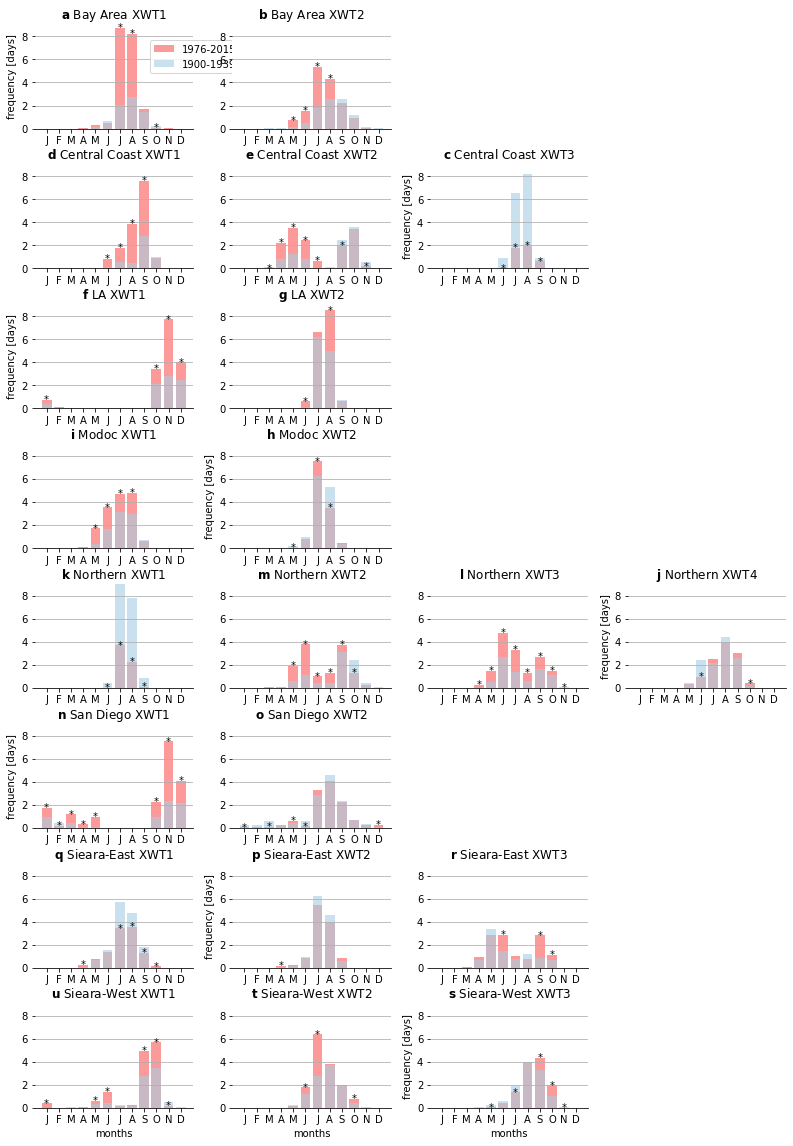

In [15]:
# ======================================
plt.rcParams.update({'font.size': 10})
rgsLableABC=list(string.ascii_lowercase)
ReturnLevel=2
Regions_RP_Z[Regions_RP_Z == np.inf]=np.nan

fig = plt.figure(figsize=(12,16))
gs1 = gridspec.GridSpec(8,4)
gs1.update(left=0.08, right=0.95,
           bottom=0.04, top=0.98,
           wspace=0.25, hspace=0.35)
sMonths = ['J','F','M','A','M','J','J','A','S','O','N','D']
ii = 0
for REG in range(len(SortXWTs)):
    for wt in range(len(SortXWTs[REG])):
        WT = SortXWTs[REG][wt]
        ax = plt.subplot(gs1[REG,WT])
        sMonthsAct = np.copy(sMonths); sMonthsAct[:] = ' '
        # NOAA
        Past=np.mean(Montlhy_ocXWT20CR[:,REG,:,wt,0], axis=0)
        errorP = np.std(Montlhy_ocXWT20CR[:,REG,:,wt,0], axis=0)
        Current=np.mean(Montlhy_ocXWT20CR[:,REG,:,wt,1], axis=0)
        errorC = np.std(Montlhy_ocXWT20CR[:,REG,:,wt,1], axis=0)
        # are changes significant?
        MWU_P = np.zeros((12)); MWU_P[:] = np.nan
        for mm in range(12):
            try:
                MWU_P[mm] = scipy.stats.mannwhitneyu(Montlhy_ocXWT20CR[:,REG,mm,wt,0], Montlhy_ocXWT20CR[:,REG,mm,wt,1])[1]
                if MWU_P[mm] < 0.025:
                    sMonthsAct[mm] = '*'
            except:
                continue

        plt.bar(range(1,13), Current, align='center', alpha=1, color="#fb9a99", label='1976-2015') #, yerr=errorP)
        plt.bar(range(1,13), Past, align='center', alpha=0.6, color="#a6cee3", label='1900-1939')#, yerr=errorC)
        # show significance
        [plt.text(mm, Current[mm-1], sMonthsAct[mm-1], ha = 'center', va = 'center') for mm in range(1,13)]
        if wt == 0:
            ax.set_ylabel('frequency [days]')
        if REG == 7:
            ax.set_xlabel('months')
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        # ax.text(0.05,0.95, rgsLableABC[2]+') monthly event\nfrequency in '+sRegion, ha='left',va='top', \
        #                  transform = ax.transAxes, fontname="Times New Roman Bold", fontsize=16) #, weight='bold')
        plt.title(r"$\bf{" + str(rgsLableABC[ii])+ "}$"+' '+REGIONS[REG]+' XWT'+str(WT+1))
        if (wt == 0) & (REG == 0):
            plt.legend(bbox_to_anchor=(0.7,0.9))
        plt.grid(axis='y')
        ax.set_xticks((1,2,3,4,5,6,7,8,9,10,11,12))
        ax.set_xticklabels(sMonths)
        plt.ylim([0,9])
        ii = ii+1

# Save the plot
# plt.show()
sPlotFile=sPlotDir
sPlotName= 'ERA20C_XWT-frq-changes_AnnualCycle.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName)

### Onset and Decay of XWT in regions

        Plot map to: /glade/u/home/prein/projects/2019_Janice-CA-Fire-WTs/plots/XWTs_in_ERA20C/ERA20C_XWT-onset-decay.pdf


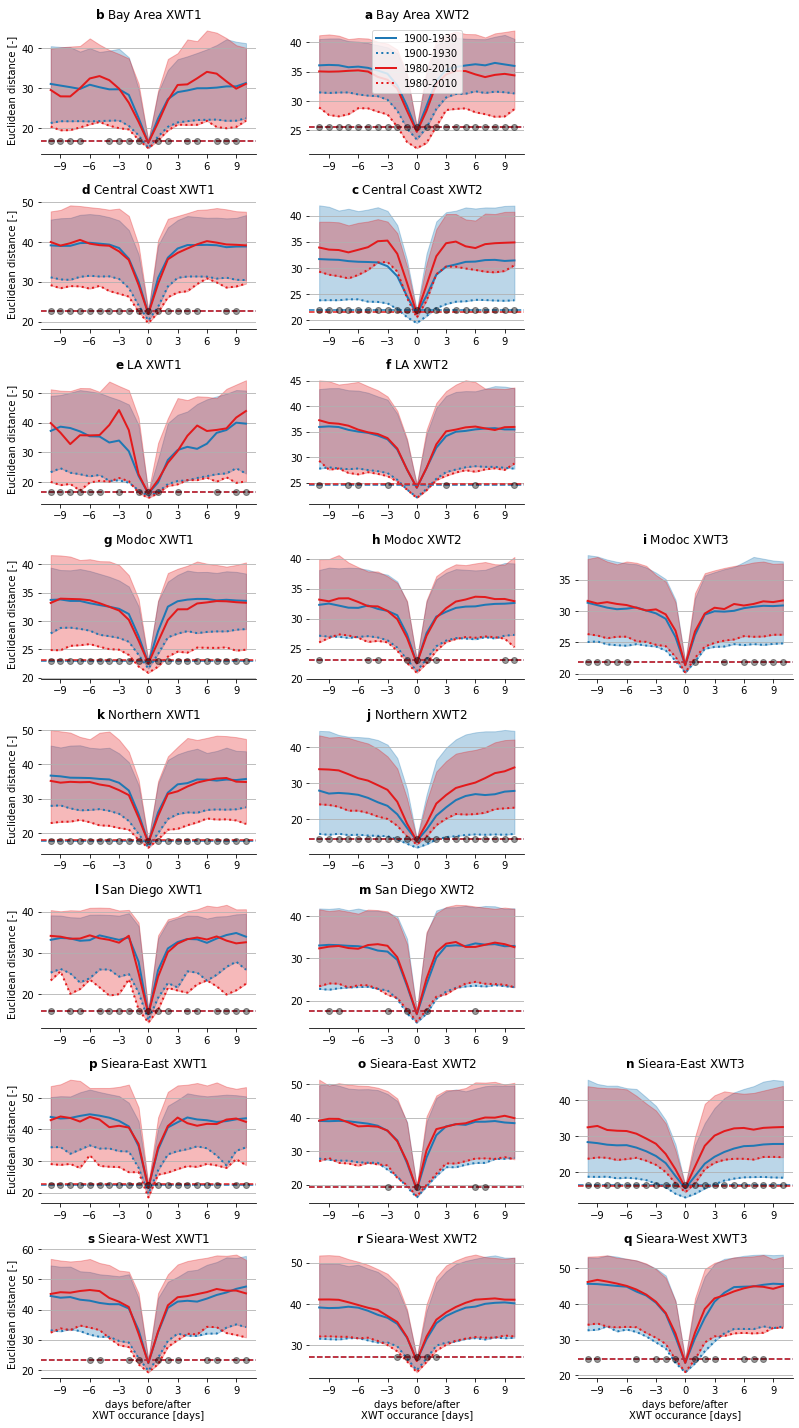

In [38]:
# ======================================
plt.rcParams.update({'font.size': 10})
rgsLableABC=list(string.ascii_lowercase)
ReturnLevel=2
Regions_RP_Z[Regions_RP_Z == np.inf]=np.nan

fig = plt.figure(figsize=(12,20))
gs1 = gridspec.GridSpec(8,3)
gs1.update(left=0.08, right=0.95,
           bottom=0.04, top=0.98,
           wspace=0.25, hspace=0.35)

iDays=10
RP=1/3. #0.3
Xaxis=np.array(range(iDays*2+1))-iDays
Percentiles = [0,25,50,75,100]

ii = 0
for REG in range(len(SortXWTs)):
    file2 = open(PreprocessedData20CR+'20CR_v3_XWTs_Eucledian-Distances_'+Regions[REG]+'.pkl', 'rb')
    DATA = pickle.load(file2)
    for wt in range(len(SortXWTs[REG])):
        EventOnsetDecay = np.zeros((2,len(SortXWTs[REG]),80, len(Percentiles), iDays*2+1)); EventOnsetDecay[:]=np.nan
        ED_max = np.zeros((2,len(SortXWTs[REG]),80)); ED_max[:] = np.nan
        WT = SortXWTs[REG][wt]
        ax = plt.subplot(gs1[REG,WT])
        for mem in range(80):
            re = REG
            SRdata=DATA[Regions[re]+'_'+str(mem).zfill(3)]
            EucledianDist=SRdata['EucledianDist_orig']

            E20YYYY=np.unique(E20_time20CR.year)
            MinED=EucledianDist[:,wt]

            # get index of top events
            EventsTotal=int(np.round(len(E20YYYY)*RP, 0))
            TopEvED=np.sort(MinED)[:EventsTotal]
            iTopEv=np.array([np.where(TopEvED[ii] == MinED)[0][0] for ii in range(len(TopEvED))])

            # cut out days before and after the event in first 40 years and last 40 years
            HitsPer=np.where(E20_time.year < 1930)[0][-1]
            Current=np.where(E20_time.year > 1980)[0][0]
            EventComposit=np.zeros((iDays*2+1,len(iTopEv))); EventComposit[:]=np.nan
            for ev in range(len(iTopEv)):
                EventComposit[:,ev]=MinED[iTopEv[ev]-iDays:iTopEv[ev]+iDays+1]
            Hist=(iTopEv <= HitsPer)
            Curr=(iTopEv >= Current)
            EventOnsetDecay[0,wt,mem,:,:] = np.percentile(EventComposit[:,Hist], Percentiles,axis=1) 
            EventOnsetDecay[1,wt,mem,:,:] = np.percentile(EventComposit[:,Curr], Percentiles,axis=1) 

            ED_max[0,wt,mem] = np.max(EventComposit[iDays,Hist])
            ED_max[1,wt,mem] = np.max(EventComposit[iDays,Curr])

        plt.fill_between(Xaxis,np.mean(EventOnsetDecay[0,wt,:,0,:], axis=0), np.mean(EventOnsetDecay[0,wt,:,4,:], axis=0), color='#1f78b4', alpha=0.3)
        plt.fill_between(Xaxis,np.mean(EventOnsetDecay[1,wt,:,0,:], axis=0), np.mean(EventOnsetDecay[1,wt,:,4,:], axis=0), color='#e31a1c', alpha=0.3)

        plt.plot(Xaxis, np.mean(EventOnsetDecay[0,wt,:,2,:],axis=0), c='#1f78b4', lw=2, label='1900-1930')
        plt.plot(Xaxis, np.mean(EventOnsetDecay[0,wt,:,0,:],axis=0), c='#1f78b4', lw=2, label='1900-1930', ls=':')
        plt.plot(Xaxis, np.mean(EventOnsetDecay[1,wt,:,2,:],axis=0), c='#e31a1c', lw=2, label='1980-2010')
        plt.plot(Xaxis, np.mean(EventOnsetDecay[1,wt,:,0,:],axis=0), c='#e31a1c', lw=2, label='1980-2010', ls=':')

        # Min XWT threshold
        plt.axhline(y=np.mean(ED_max[0,wt,:]), color='#1f78b4', linestyle='--')
        plt.axhline(y=np.mean(ED_max[1,wt,:]), color='#e31a1c', linestyle='--')

        # indicate significance
        for dd in range(len(Xaxis)):
            SIG = scipy.stats.mannwhitneyu(EventOnsetDecay[0,wt,:,0,dd], EventOnsetDecay[1,wt,:,0,dd])[1]
            if SIG <= 0.025:
                plt.plot(Xaxis[dd], np.mean(ED_max[0,wt,:]), 'ko', alpha=0.4)

        if REG == 7:
            ax.set_xlabel('days before/after\nXWT occurance [days]')
        if WT == 0:
            ax.set_ylabel('Euclidean distance [-]')
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.title(r"$\bf{" + str(rgsLableABC[ii])+ "}$"+' '+REGIONS[REG]+' XWT'+str(WT+1))
        if (wt == 0) & (REG == 0):
            plt.legend(loc="top left")
        plt.grid(axis='y')
        ax.set_xticks((-9,-6,-3,0,3,6,9))
        ii = ii+1
        
# Save the plot
# plt.show()
sPlotFile=sPlotDir
sPlotName= 'ERA20C_XWT-onset-decay.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName)